# Instalação de Bibliotecas

In [ ]:
!pip install scikit-fuzzy

   ---------------------------------------- 0.0/920.8 kB ? eta -:--:--
   ---------------------------------- ----- 786.4/920.8 kB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 920.8/920.8 kB 8.7 MB/s eta 0:00:00


# Importação de Bibliotecas Necessárias

In [110]:
# Importação de Biblioteca Fuzzy
import skfuzzy as fuz
# Importação de Biblioteca de Controlador Fuzzy
from skfuzzy import control as ctrl
# Importação de Biblioteca para Definir Regras Fuzzy
from skfuzzy.control.rule import Rule
# Importação de Biblioteca para Definir Termos Fuzzy
from skfuzzy.control.term import Term, WeightedTerm
# Importação de Biblioteca para Definir Antecedentes e Consequentes
from skfuzzy.control.antecedent_consequent import Antecedent, Consequent
# Importação de Bibliotecas para Visualização
import matplotlib.pyplot as plt
# Importação de Biblioteca para Visualização de Regras
from matplotlib.lines import Line2D
# Importação de Biblioteca para Manipulação de Arrays
import numpy as np
# Importação de Biblioteca para Visualização de Grafos
import networkx as nx

## Pertinência triangular x trapezoidal
Usando as funções de pertinência triangulares, alguns valores acambam sendo muito baixos, e outros nulos.

O problema de usarmos funções de pertinência triangulares é que isso aumenta o nível de incerteza do sistema, o único ponto de certeza absoluta seria o pico do triângulo (pertinência = 1.0). Por exemplo, quando a bateria está em 100%, o valor de pertinência será 0.01, pois 100% está no início da subida da função 'Bateria Alta'. Para que isso represente uma decisão que seria tomada corretamente, 100% deveria ter um valor de pertinência de 1.0 até que em 50% haja uma transição para bateria Baixa até em extremamente Baixa.

## Pertinência de Bateria

Para definir-mos quais os valores ideais de pertinência da **bateria**, é necessário compreender o problema em questão: Diminuir o consumo da bateria durante o upload de dados. Queremos que essa diminuição de consumo, aconteça desde o início (bateria alta) e que seja mais criterioso quando a bateria estiver **muito baixa** ou em **reserva**. Talvez então possamos definir um aumento de critério de **muito alto -> alto** menos abrubto do que **média -> baixa**
* Muito Alta e Alta: entre 100% e 50%
    * Muito Alta: 100 - 75%
    * Alta: 75 - 50 %
* Baixa e Muito Baixa: 50 - 15%
    * Baixa: 50 - 30%
    * Muito Baixa: 30 - 15%
* Reserva: 15 - 0% de bateria

A bateria na reserva não irá mais procurar sinal GPRS, para que a prioridade seja tentar enviar o sinal quando a qualidade estiver a mínima suficiente possível. Também, nesse tempo entre 15% e 0% de bateria, os pesquisadores irão procurar o sinal via triangulação usando o módulo GSM, mas nesse caso em específico, não temos o GSM.


## Pertinência de Qualidade do Sinal

De outra forma, para definir-mos quais os valores ideais de pertinência da **taxa de acerto**, devemos saber quais os valores em que temos uma certeza absoluta para sucesso, e quais teremos para fracasso. A ideia principal era armazenar pontos de localização em que já foi feito algum envio ou tentativa de envio de dados e usar isso para definir uma taxa de acerto. Isso porque, como se trata de uma coleira de monitoramento animal, alguns deles tendem a andar ou voltar pelo caminho de onde vieram, e como apenas fatores temporais (chuva, nuvem, tempestade) afetariam a qualidade do sinal, outros fatores do ambiente (vegetação, profundidade) seriam os mesmos.

Porém, isso demandaria muito tempo, e além disso, existem diversos fatores não controláveis que poderiam interferir nessa lógica. O módulo SIM900 devolve alguns valores em relação ao sinal 2,5G e 3G que podem ser usados para definir quando ligar o gps para procurar o satélite e mandar a informação via pacote de dados (isso demanda um intervalo de tempo relativamente grande para o problema). O valor **+CSQ: \<rssi\>,\<ber\>** devolve informações sobre a qualidade do sinal, de acordo com o documento _CSQ-Commands-information_:
* RSSI: Força do sinal
    * 0 a 9: Sinal Muito Fraco/Marginal. Pode causar perda de pacotes, alta latência ou falha no envio de dados.
    * 10 a 14: Sinal Regular. Funciona para mensagens simples (SMS), mas pode ser instável para conexões GPRS/HTTP constantes.
    * 15 a 19: Sinal Bom. Nível recomendado para garantir que as informações sejam enviadas sem retransmissões frequentes.
    * 20 a 31: Sinal Excelente. Ideal para qualquer tipo de transmissão de dados.
    * 99: Sinal Desconhecido ou inexistente (módulo não encontrou rede ou antena desconectada).
* BER: _Bit error rate_ (taxa de erro de bits). Esse valor só é detectado durante a **transmissão de informações**. Portanto, não será usado para medir a qualidade do sinal antes de mandar informações.

Dessa forma, ao invés de **Taxa de Acerto** será usado uma **Qualidade do Sinal**, de acordo com as especificações acima.

# Saída
É importante ressaltar que, deseja-se uma saída representada por um valor de probabilidade. Para isso **todas** as inferências devem se comportar como probabilidades. Ou seja, as transições entre as funções de inferência da bateria e da qualidade do sinal, ao traçar um ponto qualquer desses valores, a soma dos valores de inferência das funções devem ser igual a 100. Por isso que em cada uma, o começo do triângulo ou do trapézio sempre será o início da descida do que antecede, e assim por diante.

A inferência de saída por sua vez, deve também ter esse comportamento.



c:\Users\Arthur\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


(None, None, None)

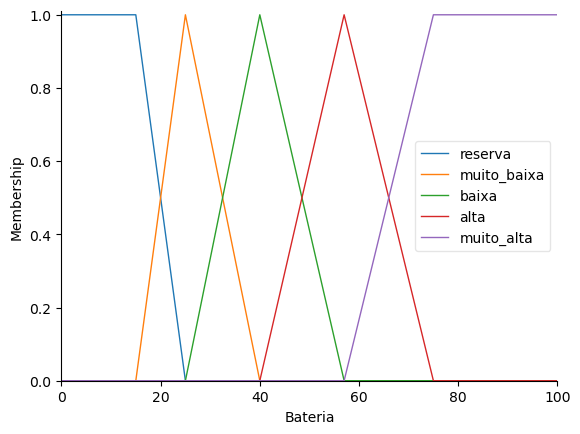

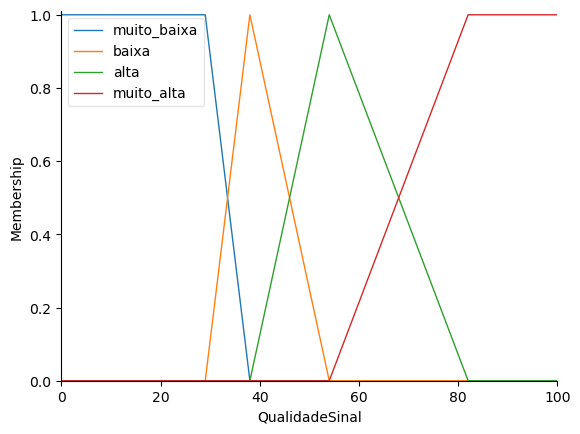

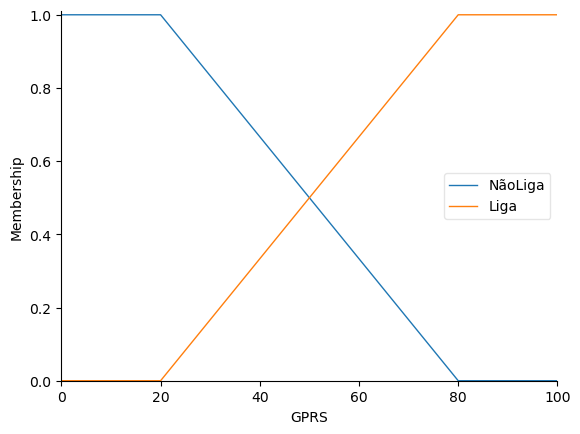

In [107]:
universe = universe = np.linspace(0, 101, 5)

Bateria = ctrl.Antecedent(np.arange(0, 101, 1), 'Bateria')

# optou-se por aumentar a transição de bateria muito baixa para reserva pra 15% para que o sistema seja mais conservador, e não corra o risco de ligar o GPRS quando a bateria estiver em um nível crítico.

# usa-se cálculos de média para que os valores entre inferências seja sempre relacionados a uma probabilidade 
# Ex.: 0.4 bateria muito alta + 0.6 bateria alta = 100.

# Reserva: 15 - 0
# de 7.5% a 0% é certeza que a bateria está em reserva.
Bateria['reserva'] = fuz.trapmf(Bateria.universe, [0,0,15,25])
# muito baixa: 30 - 15
Bateria['muito_baixa'] = fuz.trapmf(Bateria.universe, [15,25,25,int((50+30)/2)])
# baixa: 50 - 30
Bateria['baixa'] = fuz.trapmf(Bateria.universe, [25,int((50+30)/2),int((50+30)/2),int((75+40)/2)])
# alta: 75 - 50
Bateria['alta'] = fuz.trapmf(Bateria.universe, [int((50+30)/2),int((75+40)/2),int((75+40)/2),75])
# muito alta: 100 - 75
# de 100% a 75% é certeza que a bateria está em muito alta. 
Bateria['muito_alta'] = fuz.trapmf(Bateria.universe, [int((75+40)/2),75,100,100])

QualidadeSinal = ctrl.Antecedent(np.arange(0,101,1), 'QualidadeSinal')

# Essa taxa deve ser normalizada para valores entre 0 e 100, tal que os valores entregues pelo SIM7020E são valores entre 0 e 31, e 99 quando indeterminado. O incerteza será de 2 pontos para mais ou para menos, ou seja, um valor de 15 pode ser considerado como 13, 14, 15, 16 ou 17. Nesse caso, não é certeza que o valores de pertinência se encaixe perfeitamente em uma categoria, pois o sinal irá mudar (o animal poderá continuar em movimento) e, além disso, não se é certeza que 2 pontos de incerteza sejam suficientes para cobrir a variação do sinal, mas é uma estimativa razoável para o sistema tomar decisões. 

# A formula de normalização é: (valor * 100) / 31

def nrm_q(valor):
    return int((valor * 100) / 31)

# muito baixa: 0 a 9
QualidadeSinal['muito_baixa'] = fuz.trapmf(QualidadeSinal.universe, [0,0,nrm_q(9),nrm_q((10+14)/2)])
# baixa: 10 a 14
QualidadeSinal['baixa'] = fuz.trapmf(QualidadeSinal.universe, [nrm_q(9),nrm_q((10+14)/2),nrm_q((10+14)/2),nrm_q((15+19)/2)])
# alta: 15 a 19
QualidadeSinal['alta'] = fuz.trapmf(QualidadeSinal.universe, [nrm_q((10+14)/2),nrm_q((15+19)/2),nrm_q((15+19)/2),nrm_q((20+31)/2)])
# muito alta: 20 a 31
QualidadeSinal['muito_alta'] = fuz.trapmf(QualidadeSinal.universe, [nrm_q((15+19)/2),nrm_q((20+31)/2),100,100])

GPRS = ctrl.Consequent(np.arange(0,101,1), 'GPRS')

# A saída tem a especificação de que a transição entre as decisões seja mais suave, e que o grau de incerteza entre escolher ligar ou desligar seja maior, fazendo com que o sistema seja mais criterioso.

# foi definido um espaço de incerteza de 30 pontos, ou seja, nesse intervalo o sistema irá considerar que tanto ligar quanto não ligar são opções plausíveis, e irá tomar a decisão com base no grau de pertinência de cada categoria.

# Nesse caso, o desejo é que mais dados de posição sejam enviados, e que a exceção seja não enviar os dados. Portanto, a saída "Liga" tem um intervalo de pertinência maior, e a saída "NãoLiga" tem um intervalo de pertinência menor, para que o sistema seja mais propenso a ligar o GPRS do que a não ligar, mesmo quando os dados de entrada estiverem em um nível intermediário.

GPRS['NãoLiga'] = fuz.trapmf(GPRS.universe, [0,0,20,80])
GPRS['Liga'] = fuz.trapmf(GPRS.universe, [20,80,101,101])

regras1_1 = ctrl.Rule(Bateria['reserva'] & QualidadeSinal['muito_alta'], GPRS['Liga'])
regras1_2 = ctrl.Rule(Bateria['reserva'] & QualidadeSinal['alta'], GPRS['NãoLiga'])
regras1_3 = ctrl.Rule(Bateria['reserva'] & QualidadeSinal['baixa'], GPRS['NãoLiga'])
regras1_4 = ctrl.Rule(Bateria['reserva'] & QualidadeSinal['muito_baixa'], GPRS['NãoLiga'])

regras2_1 = ctrl.Rule(Bateria['muito_baixa'] & QualidadeSinal['muito_alta'], GPRS['Liga'])
regras2_2 = ctrl.Rule(Bateria['muito_baixa'] & QualidadeSinal['alta'], GPRS['Liga'])
regras2_3 = ctrl.Rule(Bateria['muito_baixa'] & QualidadeSinal['baixa'], GPRS['NãoLiga'])
regras2_4 = ctrl.Rule(Bateria['muito_baixa'] & QualidadeSinal['muito_baixa'], GPRS['NãoLiga'])

regras3_1 = ctrl.Rule(Bateria['baixa'] & QualidadeSinal['muito_alta'], GPRS['Liga'])
regras3_2 = ctrl.Rule(Bateria['baixa'] & QualidadeSinal['alta'], GPRS['Liga'])
regras3_3 = ctrl.Rule(Bateria['baixa'] & QualidadeSinal['baixa'], GPRS['NãoLiga'])
regras3_4 = ctrl.Rule(Bateria['baixa'] & QualidadeSinal['muito_baixa'], GPRS['NãoLiga'])

regras4_1 = ctrl.Rule(Bateria['alta'] & QualidadeSinal['muito_alta'], GPRS['Liga'])
regras4_2 = ctrl.Rule(Bateria['alta'] & QualidadeSinal['alta'], GPRS['Liga'])
regras4_3 = ctrl.Rule(Bateria['alta'] & QualidadeSinal['baixa'], GPRS['Liga'])
regras4_4 = ctrl.Rule(Bateria['alta'] & QualidadeSinal['muito_baixa'], GPRS['NãoLiga'])

regras5_1 = ctrl.Rule(Bateria['muito_alta'] & QualidadeSinal['muito_alta'], GPRS['Liga'])
regras5_2 = ctrl.Rule(Bateria['muito_alta'] & QualidadeSinal['alta'], GPRS['Liga'])
regras5_3 = ctrl.Rule(Bateria['muito_alta'] & QualidadeSinal['baixa'], GPRS['Liga'])
regras5_4 = ctrl.Rule(Bateria['muito_alta'] & QualidadeSinal['muito_baixa'], GPRS['NãoLiga'])

Bateria.view(), QualidadeSinal.view(), GPRS.view()

In [108]:
controlador = ctrl.ControlSystem([regras1_1,
                                  regras1_2,
                                  regras1_3,
                                  regras1_4,
                                  regras2_1,
                                  regras2_2,
                                  regras2_3,
                                  regras2_4,
                                  regras3_1,
                                  regras3_2,
                                  regras3_3,
                                  regras3_4,
                                  regras4_1,
                                  regras4_2,
                                  regras4_3,
                                  regras4_4,
                                  regras5_1,
                                  regras5_2,
                                  regras5_3,
                                  regras5_4])

C:\Users\Arthur\AppData\Local\Temp\ipykernel_13516\1799157366.py:86: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


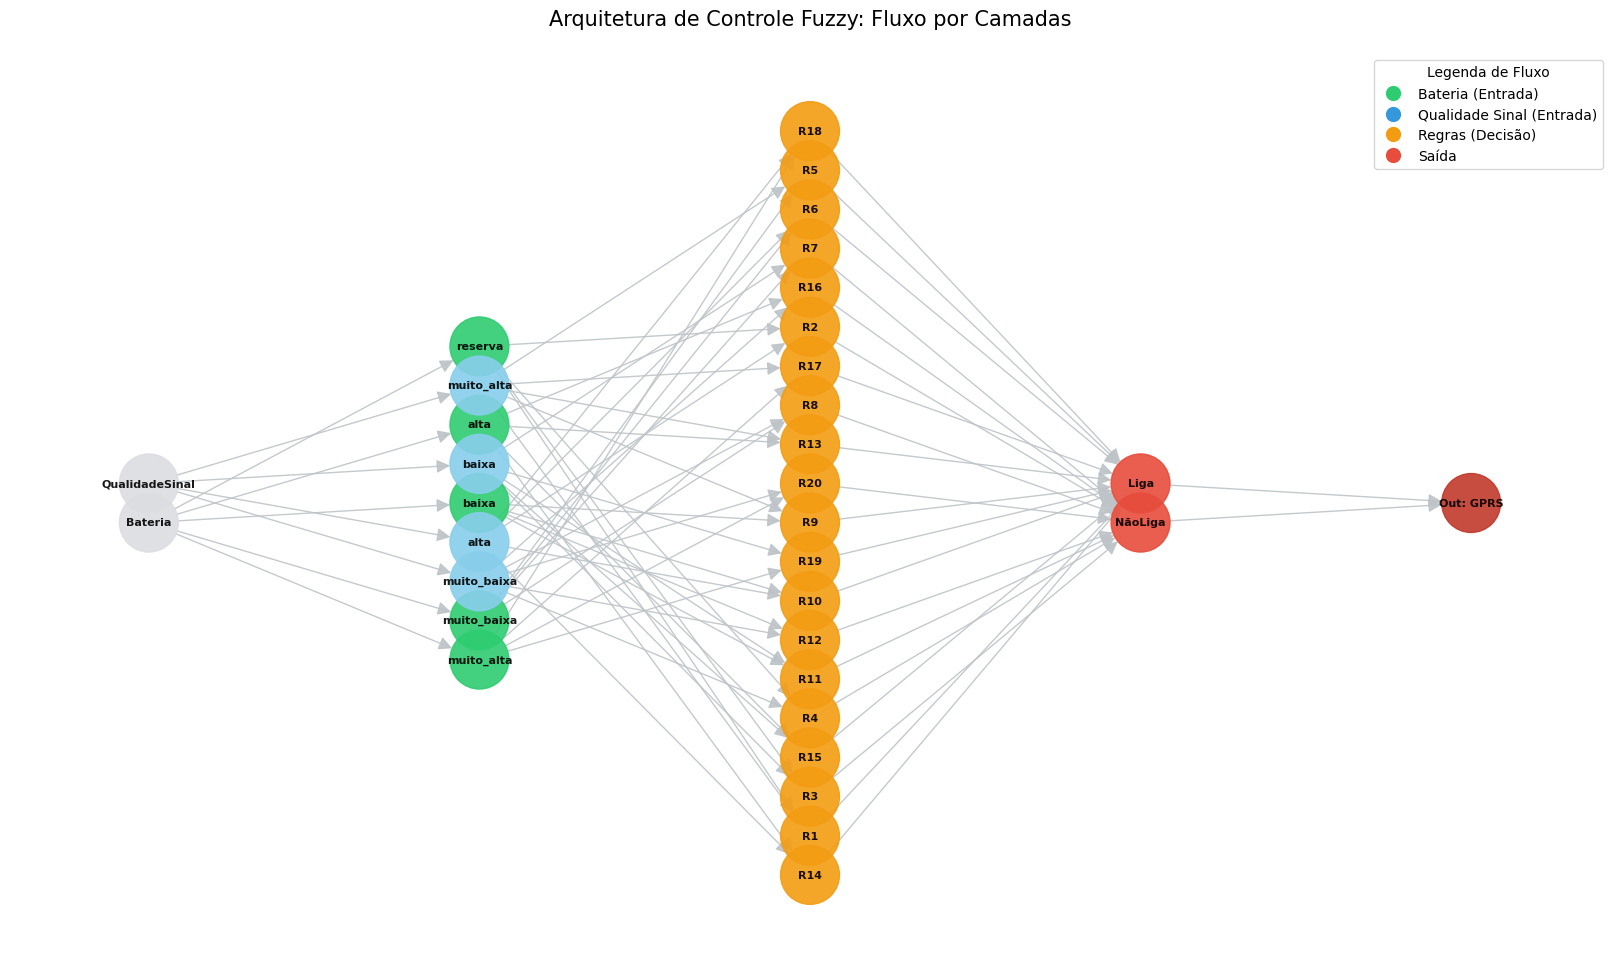

In [ ]:
# 1. Obter o grafo do controlador
G = controlador.graph


def visualizar_controlador_fuzzy(grafico_controlador):

    # 2. Mapear Camadas, Cores e Labels
    color_map = []
    labels = {}
    regra_count = 1

    for node in G.nodes():
        # CAMADA 0: Variáveis de Entrada (Os "nós" principais de entrada)
        if isinstance(node, Antecedent):
            G.nodes[node]['layer'] = 0
            color_map.append('#dcdde1') # Cinza claro
            nome = "Qualidade Sinal" if node.label == "Taxa de Acerto" else node.label
            labels[node] = f"{nome}"

        # CAMADA 1: Termos de Entrada (As categorias como 'baixo', 'médio', 'alto')
        elif isinstance(node, (Term, WeightedTerm)) and isinstance(node.parent, Antecedent):
            G.nodes[node]['layer'] = 1
            pai_nome = node.parent.label
            
            if pai_nome == "Bateria":
                color_map.append('#2ecc71') # Verde para Bateria
            elif pai_nome == "Taxa de Acerto":
                color_map.append('#3498db') # Azul para Qualidade Sinal (Taxa de Acerto)
            else:
                color_map.append('skyblue')
            labels[node] = node.label

        # CAMADA 2: Regras (Lógica de Inferência)
        elif isinstance(node, Rule):
            G.nodes[node]['layer'] = 2
            color_map.append('#f39c12') # Laranja para Regras
            labels[node] = f"R{regra_count}"
            regra_count += 1

        # CAMADA 3: Termos de Saída (Resultados da inferência)
        elif isinstance(node, (Term, WeightedTerm)) and isinstance(node.parent, Consequent):
            G.nodes[node]['layer'] = 3
            color_map.append('#e74c3c') # Vermelho para termos de saída
            labels[node] = node.label

        # CAMADA 4: Variáveis de Saída (O resultado final)
        elif isinstance(node, Consequent):
            G.nodes[node]['layer'] = 4
            color_map.append('#c0392b') # Vermelho escuro para a variável de saída
            labels[node] = f"Out: {node.label}"

    # 3. Gerar Layout em Camadas (Sem espaçamentos manuais)
    pos = nx.multipartite_layout(G, subset_key="layer")

    # 4. Desenhar o Grafo
    plt.figure(figsize=(16, 9))
    nx.draw(G, pos, 
            labels=labels, 
            with_labels=True, 
            node_color=color_map, 
            node_size=1800, 
            font_size=8,
            font_weight='bold',
            arrowsize=20,
            edge_color='#bdc3c7', # Cinza para as conexões
            alpha=0.9)

    # 5. Legenda com Line2D corrigida (usando [] para os dados X e Y)
    legend_elements = [
        Line2D([], [], marker='o', color='w', label='Bateria (Entrada)', markerfacecolor='#2ecc71', markersize=12),
        Line2D([], [], marker='o', color='w', label='Qualidade Sinal (Entrada)', markerfacecolor='#3498db', markersize=12),
        Line2D([], [], marker='o', color='w', label='Regras (Decisão)', markerfacecolor='#f39c12', markersize=12),
        Line2D([], [], marker='o', color='w', label='Saída', markerfacecolor='#e74c3c', markersize=12)
    ]
    plt.legend(handles=legend_elements, loc='upper right', title="Legenda de Fluxo")

    plt.title("Arquitetura de Controle Fuzzy: Fluxo por Camadas", fontsize=15, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

visualizar_controlador_fuzzy(G)